In [ ]:
# Some of this code is patterned after S SAI SURYATEJA · EDA_and_Sentiment_Analysis https://www.kaggle.com/code/ssaisuryateja/eda-and-sentiment-analysis/notebook

# imports
import os
import csv
import gzip

from multiprocessing import Pool, cpu_count
from typing import Tuple

from tqdm import tqdm
import pandas as pd

# constants
from google.colab import drive
drive.mount('/data', force_remount=True)

DATA_FOLDER = "/data/My Drive/Small_Kaggle_Data/"
D_TYPES = {
    'userid': 'int64',
    'username': 'str',
    'acctdesc': 'str',
    'location': 'str',
    'following': 'int64',
    'followers': 'int64',
    'totaltweets': 'int64',
    'usercreatedts': 'str',
    'tweetid': 'int64',
    'tweetcreatedts': 'str',
    'retweetcount': 'int64',
    'text': 'str',
    'hashtags': 'str',
    'language': 'category',
    'coordinates': 'str',
    'favorite_count': 'int64',
    'extractedts': 'str'
}
DATE_COLS = ['usercreatedts', 'tweetcreatedts', 'extractedts']

# functions
def load_file(input: tuple) -> pd.DataFrame:
    """ loading file function for multiprocessing. """
    path, proces_fnc = input
    with gzip.open(DATA_FOLDER + path, 'r') as f:
        df = pd.read_csv(f, index_col=0, dtype=D_TYPES, parse_dates=DATE_COLS, encoding='utf-8', quoting=csv.QUOTE_ALL)
    
    return proces_fnc(df)


def pre_process(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Basic pre-processing function. """
    if 'is_retweet' in df.columns:
        df = df[df['is_retweet'] != True]
        
    df = df[df['language'] == 'en']
    df['text'] = df['text'].str.lower()
    
    sample = df.sample(frac=0.01)

    return sample, df

Mounted at /data


In [ ]:
# Get all data files.
files = os.listdir(DATA_FOLDER)

# Create inputs for load_file function. (we pass the pre processing logic separately so we can use different preprocessing logic later.)
input = [(file, pre_process) for file in files]

# Create pool of workers to do file loading and some preprocessing in parallel.
with Pool(cpu_count()) as pool:
    results = pool.map(load_file, input)

en_tweet_dfs, dfs = zip(*results)
# Concat samples into one large sample and save it.
sample = pd.concat(en_tweet_dfs)
quotes = pd.concat(dfs)

sample.to_pickle('/data/My Drive/en_tweets_sample.pkl')
quotes.to_pickle('/data/My Drive/quotes.pkl')

In [ ]:
# imports
!pip install Levenshtein
!pip install pyLDAvis
import math
import itertools
import re
import textwrap
from collections import Counter
from typing import Tuple, List

import gensim.corpora as corpora
import gensim.models
import Levenshtein as lev
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import spacy
from gensim.models import CoherenceModel
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from scipy.sparse import csr_matrix
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords

# download nltk stopwords
nltk.download("stopwords")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# constants
PRO_RUSSIA_NEGATIVE_HASHTAGS = ['MAGA', 'maga', 'MAGAForever', 'NaziUkraine', 'ukrainiannazi', 'ZelenskyWarCriminal', 'MaidanCoup', 'ProxyWar', 
                       'Fascism', 'Nazism', 'Burisma', 'Corruption', 'Corrupt', 'MySonHunter', 'AmericaFirst']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.1 MB/s 
     |████████████████████████████████| 2.2 MB 52.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=399bbbc80e57e1f3b62849ad39529a9550f62d787c6205b8055648334321fa8a
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=a301112635b2930fe6fb3113ffe67118641cb88f8eb3e4ff0935eb5cc0490912
  Stored in directory: /root/.cache/pip/wh

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# load data
sample = pd.read_pickle('/data/My Drive/en_tweets_sample.pkl')

In [ ]:
from pandas.tseries.frequencies import unique
def get_hashtags(tweets: pd.DataFrame) -> List[list]:
    """ Extract hashtags from dataset. """
    hashtags_2d_array = tweets['hashtags'].apply(lambda x: [hashtag['text'] for hashtag in eval(x)]).values.tolist()
    hashtags = [hashtag for hashtag in itertools.chain(*hashtags_2d_array)]
    return hashtags


def get_hashtags_count(tweets: pd.DataFrame) -> Counter:
    """ Count hashtags in dataset. """
    hashtags = get_hashtags(tweets)
    lowercase_hashtags = [hashtag.lower() for hashtag in hashtags]

    return Counter(lowercase_hashtags)


def count_pro_russia_ukraine_hashtag(hashtag_counter: Counter) -> int:
    """ Count pro russian hashtags. """
    pro_russia_count = sum([hashtag_counter.get(pro_russia_hashtags, 0) for pro_russia_hashtags in PRO_RUSSIA_NEGATIVE_HASHTAGS])

    return pro_russia_count


def print_tweet_texts(texts: List[str]) -> None:
    for text in texts:
        print('---------------------')
        print(textwrap.fill(text, 160))

        
def examine_tweets(tweets: pd.DataFrame, print_sample: bool = True) -> None:
    """ Examine tweets by extracting hashtags and counting known pro russian hashtags. """

    hashtags = get_hashtags_count(tweets)
    pro_russia_count = count_pro_russia_ukraine_hashtag(hashtags)
    print(f'pro russian hashtags: {pro_russia_count}')

    
    if print_sample is False:
        return
    
    print_limit = math.floor((len(tweets) / 100)) * 100
    print("print limit = {}".format(print_limit))
    print_interval = int(print_limit/10)
    print_tweet_texts(tweets['text'].values[0:print_limit:print_interval])
    
print('full sample', len(sample))
examine_tweets(sample, False)
all_hashtags = get_hashtags(sample)
print('all_hashtags', all_hashtags)
negative_sample = sample[sample['hashtags'].str.contains('MAGA') | sample['hashtags'].str.contains('maga') | sample['hashtags'].str.contains('MAGAForever') | sample['hashtags'].str.contains('NaziUkraine') 
| sample['hashtags'].str.contains('ukrainiannazi') | sample['hashtags'].str.contains('ZelenskyWarCriminal') | sample['hashtags'].str.contains('MaidanCoup') | sample['hashtags'].str.contains('ProxyWar') | 
sample['hashtags'].str.contains('Fascism') | sample['hashtags'].str.contains('Nazism') | sample['hashtags'].str.contains('Burisma') | sample['hashtags'].str.contains('Corruption') | 
sample['hashtags'].str.contains('Corrupt') | sample['hashtags'].str.contains('MySonHunter') | sample['hashtags'].str.contains('AmericaFirst') ]

print('Negative tweets:', len(negative_sample))

unique_locations = negative_sample['location'].unique()
unique_usernames = negative_sample['username'].unique()
print('Number of unique locations:', len(unique_locations))
print('List of unique locations:', unique_locations)
print('Number of unique usernames:', len(unique_usernames))
print('List of unique usernames:', unique_usernames)

print('Hashtags:', negative_sample['hashtags'].str.split('text'))
negative_hashtags = get_hashtags(negative_sample)
print('negative_hashtags', negative_hashtags)


full sample 10394
pro russian hashtags: 54
all_hashtags ['NATO', 'winter', 'Ukrainian', 'army', 'Ukraine', 'emergency', 'Russia', 'Ukraine', 'TimothySnyderspeaks', 'Putin', 'redline', 'POTUS', 'SCOTUS', 'GOP', 'DNC', 'FoxNews', 'CNN', 'Antifa', 'BlackLivesMatter', 'PONTIFEX', 'CopelandNetwork', 'UN', 'NATO', 'WSJ', 'NYSE', 'California', 'RepMTG', 'RepBoebert', 'sundayvibes', 'RussianArmy', 'Dreamspace', 'AssassinsCreed', 'SundayMotivation', 'Ukraine', 'Russia', 'crypto', 'Bitcoin', 'SPS', 'altcoins', 'memes', 'Splinterlands', 'PlayToEarn', 'doge', 'NFTs', 'inflation', 'Biden', 'HuntersCrackPipe', 'fiat', 'toiletpaper', 'emptyshelves', 'WEF', 'KlausSchwab', 'Trump', 'IRS', 'eatthebugs', 'gold', 'FBI', 'UseTheHorse', 'WeRemember911', 'NATO', 'Donetsk', 'France', 'Putin', 'Ukraine', 'Russian', 'Solovyov', 'Ukraine', 'Ukraine', 'Balakleya', 'Kharkiv', 'KharkivOblast', 'russiaisateroriststate', 'RussiaIsANaziState', 'russiaisaterrorisstate', 'IAEA', 'Zaporizhzhia', 'Russia', 'Ukraine', 'Ukr

In [ ]:
# load all data
sample = pd.read_pickle('/data/My Drive/quotes.pkl')
    
print('full data', len(sample))
examine_tweets(sample, False)
all_hashtags = get_hashtags(sample)
print('all_hashtags', all_hashtags)
#negative_sample1 = sample[sample['hashtags'].str.contains('MAGA') | sample['hashtags'].str.contains('maga') | sample['hashtags'].str.contains('MAGAForever') | sample['hashtags'].str.contains('NaziUkraine') 
#| sample['hashtags'].str.contains('ukrainiannazi') | sample['hashtags'].str.contains('ZelenskyWarCriminal') | sample['hashtags'].str.contains('MaidanCoup') | sample['hashtags'].str.contains('ProxyWar') | 
#sample['hashtags'].str.contains('Fascism') | sample['hashtags'].str.contains('Nazism') | sample['hashtags'].str.contains('Burisma') | sample['hashtags'].str.contains('Corruption') | 
#sample['hashtags'].str.contains('Corrupt') | sample['hashtags'].str.contains('MySonHunter') | sample['hashtags'].str.contains('AmericaFirst') ]

negative_sample = sample[sample['hashtags'].str.contains('NaziUkraine') 
| sample['hashtags'].str.contains('ukrainiannazi') | sample['hashtags'].str.contains('ZelenskyWarCriminal') | sample['hashtags'].str.contains('MaidanCoup') | sample['hashtags'].str.contains('ProxyWar') ]

print('Negative tweets:', len(negative_sample))

unique_locations = negative_sample['location'].unique()
print('Number of unique_locations:', len(unique_locations))
print('List of unique_locations:', unique_locations)

for i in range(len(unique_locations)):
  print(unique_locations[i])


unique_usernames = negative_sample['username'].unique()
print('Number of unique usernames:', len(unique_usernames))
print('List of unique usernames:', unique_usernames)

for i in range(len(unique_usernames)):
  print(unique_usernames[i])


print('Hashtags:', negative_sample['hashtags'].str.split('text'))
negative_hashtags = get_hashtags(negative_sample)
negative_hashtags = set(negative_hashtags)
negative_hashtags = (list(negative_hashtags))
print('unique negative_hashtags', negative_hashtags)


full data 1039613
pro russian hashtags: 6277


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Negative tweets: 1757
Number of unique_locations: 310
List of unique_locations: [nan 'BOLIVIA ' 'DemocratizeTheMedia.Us' 'Tromsø, Norge'
 'Somwher in ze midle of nowhere' 'Rimini' '#plagueisland☣'
 'Anti-Social Media Jail' 'Chadbourn, NC' 'Texas' 'Jacksonville, AL'
 'Planet Terra' 'Mayberry. ' 'Portland, OR' 'Santa Monica ' 'Qazvin '
 'Naples - Miami,FL - España ' 'Dubai' 'Houston, TX'
 'Citizen of The World' 'Virginia, USA' 'London' 'Globale Toilette '
 'Behind the enemy lines.' 'USA' '#BreakfastTaco in ShastaCounty'
 'Vientiane ' 'Warwickshire, UK' 'North Coast, United States' 'Κύπρος'
 'Switzerland 🇨🇭' 'Venezuela' 'Chesterfield, England'
 'New York City--- East Village' '日本' 'The Hague, The Netherlands' 'Italy'
 'United States' 'Chicago, IL' 'Evansville, IN' 'Reparations'
 'Venice, Miami, Hong Kong' 'Mayberry. No DMs.' 'Rust Belt' 'Chennai'
 'Planet Earth' "People's Republic of Albonesia" 'Twilight Zone'
 '1098RZ Amsterdam' '‘Merica' 'Waco Land' 'India' 'Dublin, Ireland'
 'Espoo, Fi

In [ ]:
#'MAGA', 'maga', 'MAGAForever', 'NaziUkraine', 'ukrainiannazi', 'ZelenskyWarCriminal', 'MaidanCoup', 'ProxyWar', 'Fascism', 'Nazism', 'Burisma', 'Corruption', 'Corrupt', 'MySonHunter', 'AmericaFirst'

examine_tweets(negative_sample)

print('Russia influence negative sentiment hashtags - nazi theme.')
hashtags = get_hashtags_count(negative_sample)
for key, value in hashtags.items():
  if value > 500:
    print(f'{key}: {value}')

print(f'\ndata shape: {negative_sample.shape}')

print('\nrussia_sample of texts - nazi theme')
print_tweet_texts(negative_sample['text'].values[0:200:20])



pro russian hashtags: 23
print limit = 1700
---------------------
it's unimaginably audacious of the @potus &amp; dems to cry about fascism &amp; ultranationalism in america when they're openly &amp; actively funding it in
ukraine. hypocrisy in its purest form.  #ukraine #ukrainiannazi
---------------------
two contrasting photos first is on the champs elysees in paris 1940 as people cry and look on in horror as the nazis march past.  the other picture is when the
nazis enter ukraine in ww2 greeted as hero's, nothings really changed in #naziukraine they're still nazis #azov #nazis https://t.co/fwq56cgbtk
---------------------
no nazis in #ukraine #zelenskywarcriminal #twitter https://t.co/dvxrcaklqc
---------------------
@zelenskyyua talks about freedom , while hes acts like a #dictator in #ukraine️ . #zelenskywarcriminal #humanrightsviolations #nuremberg2now
#crimesagainsthumanity . https://t.co/vf2g5mzzrk https://t.co/xjhrkocfuw
---------------------
is someone waking up in #ukronazi

In [ ]:
negative_sample_corpus = negative_sample['text'].to_list()
negative_sample_corpus_clean_nazi = []
for tweet_text in negative_sample_corpus:
    # remove urls and mentions
    tweet_text = re.sub(r"(?:\@|https?\://)\S+", "", tweet_text)

    # only alpha numerics.
    tweet_text = re.sub(r'[^a-zA-Z0-9]+', ' ', tweet_text)

    # remove some specific substrings
    tweet_text = tweet_text.replace('amp', '')
    negative_sample_corpus_clean_nazi.append(tweet_text)


Russia world cloud - nazi theme


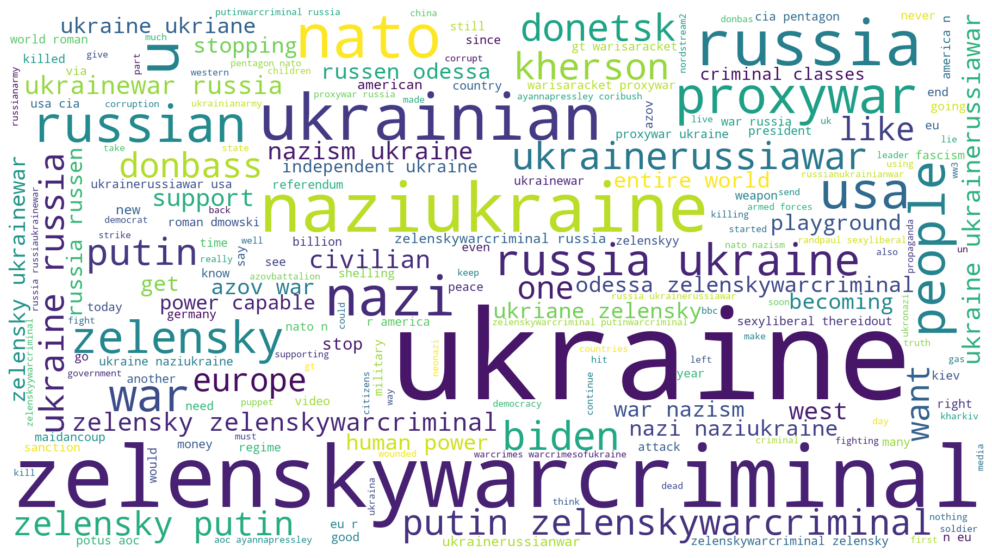

In [ ]:
en_stopwords = stopwords.words("english")
russia_wordcloud = WordCloud(background_color='white', width=1800, height=1000, stopwords=en_stopwords)
russia_wordcloud.generate_from_text(' '.join(negative_sample_corpus_clean_nazi))

print("Russia world cloud - nazi theme")
figure(figsize=(20,10))
plt.imshow(russia_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
#negative_sample = sample[sample['hashtags'].str.contains('MAGA') | sample['hashtags'].str.contains('maga') | sample['hashtags'].str.contains('MAGAForever') | sample['hashtags'].str.contains('NaziUkraine') 
#| sample['hashtags'].str.contains('ukrainiannazi') | sample['hashtags'].str.contains('ZelenskyWarCriminal') | sample['hashtags'].str.contains('MaidanCoup') | sample['hashtags'].str.contains('ProxyWar') | 
#sample['hashtags'].str.contains('Fascism') | sample['hashtags'].str.contains('Nazism') | sample['hashtags'].str.contains('Burisma') | sample['hashtags'].str.contains('Corruption') | 
#sample['hashtags'].str.contains('Corrupt') | sample['hashtags'].str.contains('MySonHunter') | sample['hashtags'].str.contains('AmericaFirst') ]

negative_sample = sample[sample['hashtags'].str.contains('MAGA') | sample['hashtags'].str.contains('maga') | sample['hashtags'].str.contains('MAGAForever') ]

print('Negative tweets:', len(negative_sample))

unique_locations = negative_sample['location'].unique()
print('Number of unique_locations:', len(unique_locations))
print('List of unique_locations:', unique_locations)

for i in range(len(unique_locations)):
  print(unique_locations[i])


unique_usernames = negative_sample['username'].unique()
print('Number of unique usernames:', len(unique_usernames))
print('List of unique usernames:', unique_usernames)

for i in range(len(unique_usernames)):
  print(unique_usernames[i])



print('Hashtags:', negative_sample['hashtags'].str.split('text'))
negative_hashtags = get_hashtags(negative_sample)
negative_hashtags = set(negative_hashtags)
negative_hashtags = (list(negative_hashtags))
print('unique negative_hashtags', negative_hashtags)

Negative tweets: 8474
Number of unique_locations: 1346
List of unique_locations: ['The World Wide Web' 'Balboa Peninsula, SoCal USA' nan ... 'Italia'
 'Empire of Lies' 'El Paso TX']
The World Wide Web
Balboa Peninsula, SoCal USA
nan
Malaysia
The caring part of your Heart
USA, Weston, Florida
Minneapolis, Minnesota USA
Pennsylvania, USA
Here, now.
Glasgow, Scotland
Miami, FL
Los Angeles, CA
Somewhere near the Amish
VALPARAISO, IN 🇺🇸
Global 🇺🇸🇦🇺🌎
Easton, PA 🇺🇸
Bloomfield, NJ 🇺🇸
Japan
Princeton, Texas
United States
Brisbane from Yorkshire
LONDINIUM
S Texas   ✞ 🙏 🇺🇸 🦅
Oak Park, IL
Galveston Island
United States of America
Florida, USA
NotChicago, IL
Langley
Reality. There is no Planet B
Zurich, Switzerland
Virginia, USA
Mississauga Ontario
Central Florida, USA
Virginia
Prescott, AZ
Texas
USA
Raleigh, NC
NYC
Pisgah National Forest
Bryn Mawr, PA
Followed by @BarackObama
Walnut Creek, CA
Upstate New York
ahead of the curve
Dog House
Colorado, USA
Deutschland
The Beach USA 🇺🇸🇺🇸🇺🇸
Boston
Greenl

In [ ]:
examine_tweets(negative_sample)

print('Russia influence negative sentiment hashtags - MAGA theme.')
hashtags = get_hashtags_count(negative_sample)
for key, value in hashtags.items():
  if value > 500:
    print(f'{key}: {value}')

print(f'\ndata shape: {negative_sample.shape}')

print('\nrussia_sample of texts - MAGA theme')
print_tweet_texts(negative_sample['text'].values[0:200:20])



pro russian hashtags: 5843
print limit = 8400
---------------------
the only way we can survive #biden's dictatorial reign of darkness, is to remain faithful to #trump's #maga teachings, the constitution &amp; the teachings of
#jesus. #magaforever
---------------------
extreme maga republicans want a secure border and legal immigration. #maga  real extremists want an open border: human trafficking, rape, drug trafficking,
terrorist infiltration, overwhelmed social services, and crime.  #democrats #biden #bordercrises
---------------------
bored to happy in a few seconds.   1st graders in kazakhstan.   #ukrainewar #ukraine #russia #ukrainerussiawar #putin #maga #俄罗斯 #乌克兰 https://t.co/dgwme6mndg
---------------------
tonight @77wabcradio: taking calls on new details of what was seized in #maralago raid &amp; is #biden’s anti-#maga rhetoric designed to deflect from his own
record? also, @toddstarnes at 10:10pmet on #memphiskidnapping case &amp; @andrewnagorski at 11:35pm on #savingfreud f

In [ ]:
negative_sample_corpus = negative_sample['text'].to_list()
negative_sample_corpus_clean_maga = []
for tweet_text in negative_sample_corpus:
    # remove urls and mentions
    tweet_text = re.sub(r"(?:\@|https?\://)\S+", "", tweet_text)

    # only alpha numerics.
    tweet_text = re.sub(r'[^a-zA-Z0-9]+', ' ', tweet_text)

    # remove some specific substrings
    tweet_text = tweet_text.replace('amp', '')
    negative_sample_corpus_clean_maga.append(tweet_text)

Russia world cloud


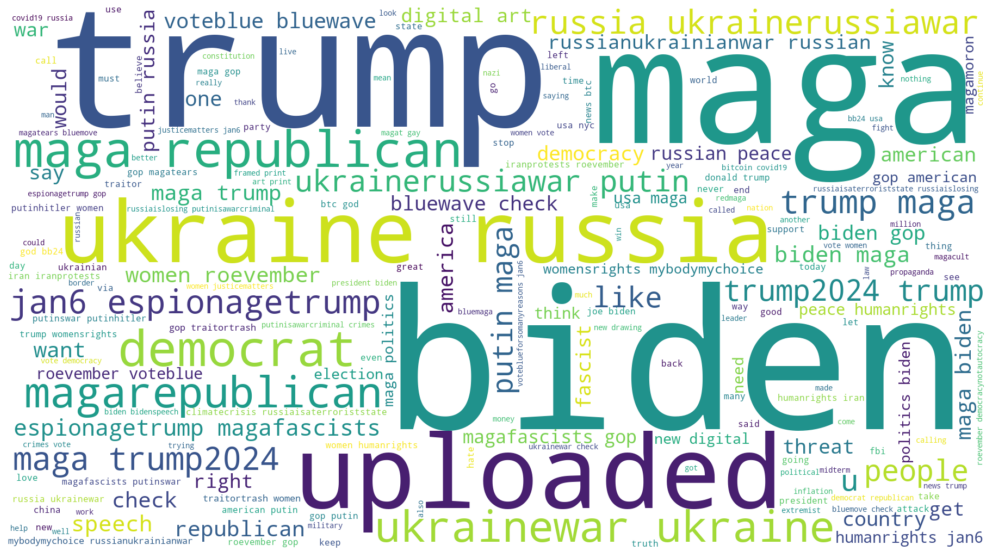

In [ ]:
en_stopwords = stopwords.words("english")
russia_wordcloud = WordCloud(background_color='white', width=1800, height=1000, stopwords=en_stopwords)
russia_wordcloud.generate_from_text(' '.join(negative_sample_corpus_clean_maga))

print("Russia world cloud")
figure(figsize=(20,10))
plt.imshow(russia_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
# tokenisation
#corpus_tokenized = [gensim.utils.simple_preprocess(tweet, deacc=True, min_len=2) for tweet in russia_putin_quotes_corpus_clean]
corpus_tokenized = [gensim.utils.simple_preprocess(tweet, deacc=True, min_len=2) for tweet in negative_sample_corpus_clean_nazi]

print('\nTokenized corpus, example:')
print(' '.join(corpus_tokenized[0][:25]))

# lemmetization and remove stopwords
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])    
corpus_lemmetized = []
for tweet_tokens in corpus_tokenized:
    tweet_tokens = nlp(' '.join(tweet_tokens))
    tokens_no_stopwords = [token for token in tweet_tokens if str(token) not in en_stopwords]
    tokens_lemmatized = [token.lemma_ for token in tokens_no_stopwords if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]
    corpus_lemmetized.append(tokens_lemmatized)

print('\nLemmetized corpus and removed stopwords, example:')
print(' '.join(corpus_lemmetized[0][:25]))
    
# create bigrams
phrase_detector = gensim.models.Phrases(corpus_lemmetized, min_count=5, threshold=20.0)
corpus_bigrams = [phrase_detector[tweet] for tweet in corpus_lemmetized]

print('\nCreated bigrams:')
print(set([word for word in itertools.chain.from_iterable(corpus_bigrams) if '_' in word]))

# Get word dictionary and bag of words for gensim implementation of LDA.
id2word = corpora.Dictionary(corpus_bigrams)
corpus_bow = [id2word.doc2bow(tweet_tokens) for tweet_tokens in corpus_bigrams]

# Get sparse matrix for sklearn implementation of LDA.
vectorizer = CountVectorizer(analyzer='word', min_df=3)
corpus_vectorized = vectorizer.fit_transform([' '.join(tweet_tokens) for tweet_tokens in corpus_bigrams])

print(f'\n vectorized corpus to sparse matrix with shape: {corpus_vectorized.shape}')


Tokenized corpus, example:
it unimaginably audacious of the dems to cry about fascism in america when they re openly actively funding it in ukraine hypocrisy in its purest

Lemmetized corpus and removed stopwords, example:
unimaginably audacious dem cry fascism openly actively fund hypocrisy pure form

Created bigrams:
{'great_american', 'spend_year', 'maybe_far', 'war_nazism', 'power_plant', 'elect_yanukovych', 'immoral_proxywar', 'donbass_donbassgenocide', 'warisaracket_chrislhaye', 'declare_civil', 'sexyliberal_thereidout', 'year_old', 'brainer_still', 'stock_elonmusktwitter', 'rogerwater_blm', 'entire_world', 'let_forget', 'ukranian_nazi', 'crime_commit', 'former_marxian', 'send_billion', 'pet_nazi', 'play_excellent', 'load_russianroulette', 'joebiden_unnecessary', 'become_playground', 'independent_ukraine', 'nazism_ukraine', 'roman_dmowski', 'ukraine_ukriane', 'victimizer_biden', 'satanic_bolshevik', 'vote_join', 'real_threat', 'cannon_fodder', 'playground_criminal', 'maga_republ

100%|██████████| 8/8 [04:16<00:00, 32.10s/it]


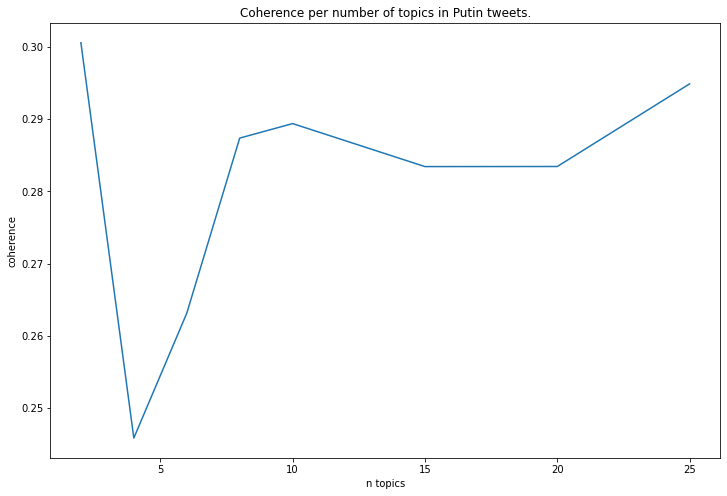

In [ ]:
n_topics_values = [2, 4, 6, 8, 10, 15, 20, 25]
coherence_results = []
for n_topics in tqdm(n_topics_values):
    coherence_lda = 0
    # try every n_topics value with 3 different random states.
    for state in [41, 42, 43]:
        lda_model = gensim.models.LdaModel(corpus=corpus_bow, id2word=id2word, num_topics=n_topics, passes=10, random_state=state)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus_bigrams, dictionary=id2word, coherence='c_v')
        coherence_lda += coherence_model_lda.get_coherence()
    
    coherence_results.append(coherence_lda / 3)

plt.figure(figsize=(12, 8))
plt.plot(n_topics_values, coherence_results)
plt.title("Coherence per number of topics in Putin tweets.")
plt.xlabel("n topics")
plt.ylabel("coherence")
plt.show()

optimal_n_topics = 8 # 4, 6 and 8 seem to do okay generally.

In [ ]:
param_grid = {'learning_decay': [.1, .3, .5, .7, .9], 'doc_topic_prior': [.1, .3, .5, .7, .9], 'topic_word_prior': [.1, .3, .5, .7, .9] }

LDA = LatentDirichletAllocation(random_state=42, batch_size=24, max_iter=10, n_components=optimal_n_topics)
grid_search_model = GridSearchCV(LDA, param_grid=param_grid, verbose=1, n_jobs=-1)
grid_search_model.fit(corpus_vectorized)

print("\nParams: ", grid_search_model.best_params_)
print("Log Likelihood Score (higher is better): ", grid_search_model.best_score_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits

Params:  {'doc_topic_prior': 0.9, 'learning_decay': 0.1, 'topic_word_prior': 0.9}
Log Likelihood Score (higher is better):  -25256.014708664112


In [ ]:
pyLDAvis.enable_notebook()
visualisation = pyLDAvis.sklearn.prepare(grid_search_model.best_estimator_, corpus_vectorized, vectorizer)
visualisation

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.066331  0.108449       1        1  16.213128
7     -0.087830  0.013982       2        1  14.650930
3     -0.105704  0.038260       3        1  14.273409
6      0.039195  0.002408       4        1  12.946825
5      0.049071 -0.019717       5        1  12.616938
0      0.028689 -0.044811       6        1  10.778628
4      0.015472 -0.013397       7        1  10.715379
1     -0.005222 -0.085173       8        1   7.804763, topic_info=             Term        Freq       Total Category  logprob  loglift
1179    ukrainian  200.000000  200.000000  Default  30.0000  30.0000
735          nazi  137.000000  137.000000  Default  29.0000  29.0000
738   naziukraine  178.000000  178.000000  Default  28.0000  28.0000
1228          war  151.000000  151.000000  Default  27.0000  27.0000
895      proxywar  143.000000  143.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
983   russianarmy    1.235382   19.275126   Topic8  -6.8567  -0.1970
1172      ukraine    1.947553  263.486299   Topic8  -6.4015  -2.3570
1288     zelensky    1.352973  102.446499   Topic8  -6.7658  -1.7766
738   naziukraine    1.373956  178.982305   Topic8  -6.7504  -2.3192
939        regime    1.221875   34.038588   Topic8  -6.8677  -0.7767

[371 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
6         1  0.061501     accord
6         2  0.061501     accord
6         3  0.615014     accord
6         4  0.061501     accord
6         5  0.061501     accord
...     ...       ...        ...
1290      4  0.041096  zelenskyy
1290      5  0.041096  zelenskyy
1290      6  0.041096  zelenskyy
1290      7  0.739729  zelenskyy
1290      8  0.041096  zelenskyy

[2336 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 4, 7, 6, 1, 5, 2])

In [ ]:
best_estimator = grid_search_model.best_estimator_
topic_scores = best_estimator.transform(corpus_vectorized)
topic_names = ['topic ' + str(i+1) for i in range(optimal_n_topics)]

topic_scores = pd.DataFrame(topic_scores, columns=topic_names)
topic_scores['topic_freq'] = topic_scores[topic_names].idxmax(axis=1)
topic_scores['text'] = negative_sample_corpus_clean_nazi

topic_freq = topic_scores['topic_freq'].value_counts()
topic_freq = pd.DataFrame(topic_freq)
topic_freq['LDAvis nr'] = [i+1 for i in range(optimal_n_topics)]

topic_words = pd.DataFrame(best_estimator.components_.T, columns=topic_names)
topic_words['word'] = vectorizer.get_feature_names()

for topic_name in topic_names:
    lda_vis_nr = topic_freq.loc[topic_name]['LDAvis nr']
    freq = topic_freq.loc[topic_name]['topic_freq']
    print(f"\n{topic_name} LDAvis nr: {lda_vis_nr} freq: {freq}")
    top_10_terms = topic_words.sort_values(topic_name, ascending=False)['word'].values[:10]
    print(f"topic terms: {' '.join(top_10_terms)}")
    top_5_tweets = topic_scores.sort_values(topic_name, ascending=False)['text'].values[:10]
    print(f'\ntopic tweets:')
    for tweet in top_5_tweets:
        print('---------------------')
        print(textwrap.fill(tweet, 160))


topic 1 LDAvis nr: 5 freq: 206
topic terms: proxywar zelensky help warisaracket bring west part fascism sign crime

topic tweets:
---------------------
ali you neglected to mention that a large part of our inflation is cause by joebiden s unnecessary immoral proxywar with russia which you are helping to promote
lets not forget how msnbc helped gwbush lie us into the iraqwar warisaracket ukrainewar dnc
---------------------
 ali you neglected to mention that a large part of our inflation is cause by joebiden s unnecessary immoral proxywar with russia which you are helping to
promote lets not forget how msnbc helped gwbush lie us into the iraqwar warisaracket ukrainewar dnc
---------------------
ali you neglected to mention that a large part of our inflation is cause by joebiden s unnecessary immoral proxywar with russia which you are helping to promote
lets not forget how msnbc helped gwbush lie us into the iraqwar warisaracket ukrainewar maddow dnc
---------------------
ali you neglec